# Analysis and Visualization of the Data from the Model

In [208]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#print all rows and columns of the dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Data Import

In [209]:
output_model = pd.read_csv('models/testing/2024-06-18_1/predictions_on_model_2024-06-18_1.csv')
output_model_horizon8 = pd.read_csv('models/testing/2024-06-18_6/predictions_on_model_2024-06-18_6.csv')
output_model_horizon12 = pd.read_csv('models/testing/2024-06-25_4/predictions_on_model_2024-06-25_4.csv')

output_Southwest = pd.read_csv('models/testing/2024-06-25_5/predictions_on_model_2024-06-25_5.csv')
output_Delta = pd.read_csv('models/testing/2024-06-25_6/predictions_on_model_2024-06-25_6.csv')
output_Frontier = pd.read_csv('models/testing/2024-06-25_7/predictions_on_model_2024-06-25_7.csv')

In [210]:

path_to_save_output = 'models/testing/plots'

## Preprocessing

In [211]:
#Shift the data by 4
def shift_data_4_quarter(data):
    every_2nd_col = range(1,data.shape[1],2)
    for i in every_2nd_col:
        data.iloc[:,i+1] = data.iloc[:,i+1].shift(-4)
        data.iloc[data.iloc[:,i+1].isnull(), i] = np.nan
        data.iloc[data.iloc[:,i].isnull(), i+1] = np.nan
    return data


output_model = shift_data_4_quarter(output_model)
output_model_horizon8 = shift_data_4_quarter(output_model_horizon8)
output_model_horizon12 = shift_data_4_quarter(output_model_horizon12)
output_Southwest = shift_data_4_quarter(output_Southwest)
output_Delta = shift_data_4_quarter(output_Delta)
output_Frontier = shift_data_4_quarter(output_Frontier)

In [212]:
#Combine single airline predictions in one dataframe
output_unseen_data = output_Southwest
output_unseen_data = pd.merge(output_unseen_data, output_Delta, on='Time', how='inner')
output_unseen_data = pd.merge(output_unseen_data, output_Frontier, on='Time', how='inner')


In [213]:

#Look up table for the airline IDs
airlineIDs = [19805, 19790, 19977, 19393, 20409, 19930, 20416, 20436, 19690, 20304]
airlineNames = ['American Airlines', 'Delta', 'United', 'Southwest', 'JetBlue', 'Alaska', 'Spirit', 'Frontier', 'Hawaiian', 'SkyWest']
airlineDict = dict(zip(airlineIDs, airlineNames))

fsc_IDs = [19805, 19790, 19977, 20304] #Full service carriers
hybrid_IDs = [19393, 20409, 19930, 19690] #Hybrid carriers
lcc_IDs = [20436, 20416] #Low cost carriers



## Visualization

### Predicted vs Actual Profit for one Airline

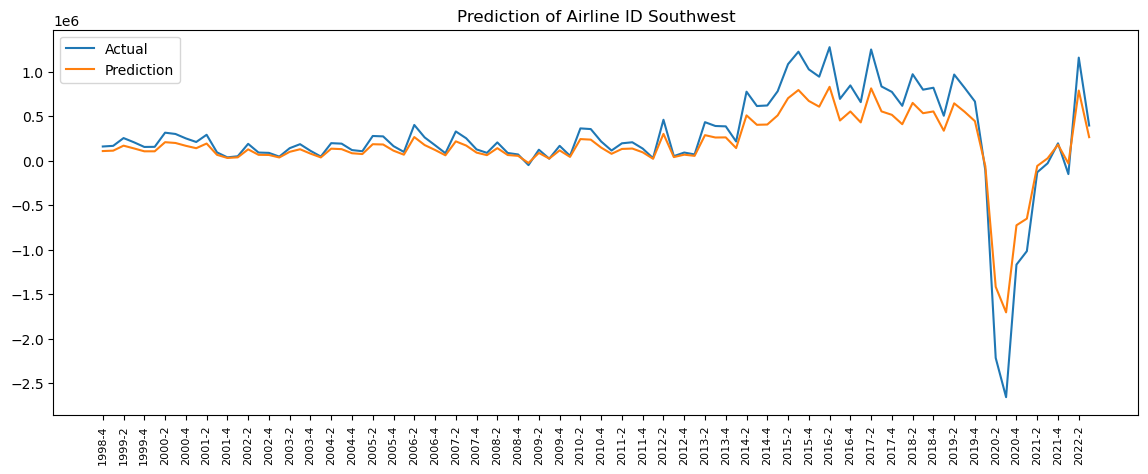

In [160]:
# Get the column indices for the current airline ID
airline_id = 19393
data_set = output_model

col_index = []
colnames = data_set.columns
for index, col in enumerate(colnames):  
    try:
        if col.split('_')[1] == str(airline_id):
            col_index.append(index)
    except:
        continue
j = col_index[0]

plt.figure(figsize=(14,5))
timescale = list(data_set[~data_set.iloc[:,j].isnull()].Time)
plt.plot(timescale, data_set[~data_set.iloc[:,j].isnull()].iloc[:,j], label='Actual')
plt.plot(timescale, data_set[~data_set.iloc[:,j].isnull()].iloc[:,j+1], label='Prediction')

id = data_set.columns[2].split('_')[1] #extract id from the column name
airline_name = airlineDict[int(airline_id)] #look up the airline name
plt.title(f'Prediction of Airline ID {airline_name}')

plt.legend()
plt.xticks(rotation='vertical', fontsize=8)

# Show only every second x-label
locs, labels = plt.xticks()  # Get locations and labels
for i, label in enumerate(labels):
    if i < len(timescale):
        label.set_text(str(timescale[i]))
plt.xticks(locs[::2], labels[::2])  # Set locations and labels


plt.show()

### Predicted vs Actual Profit for all Airline

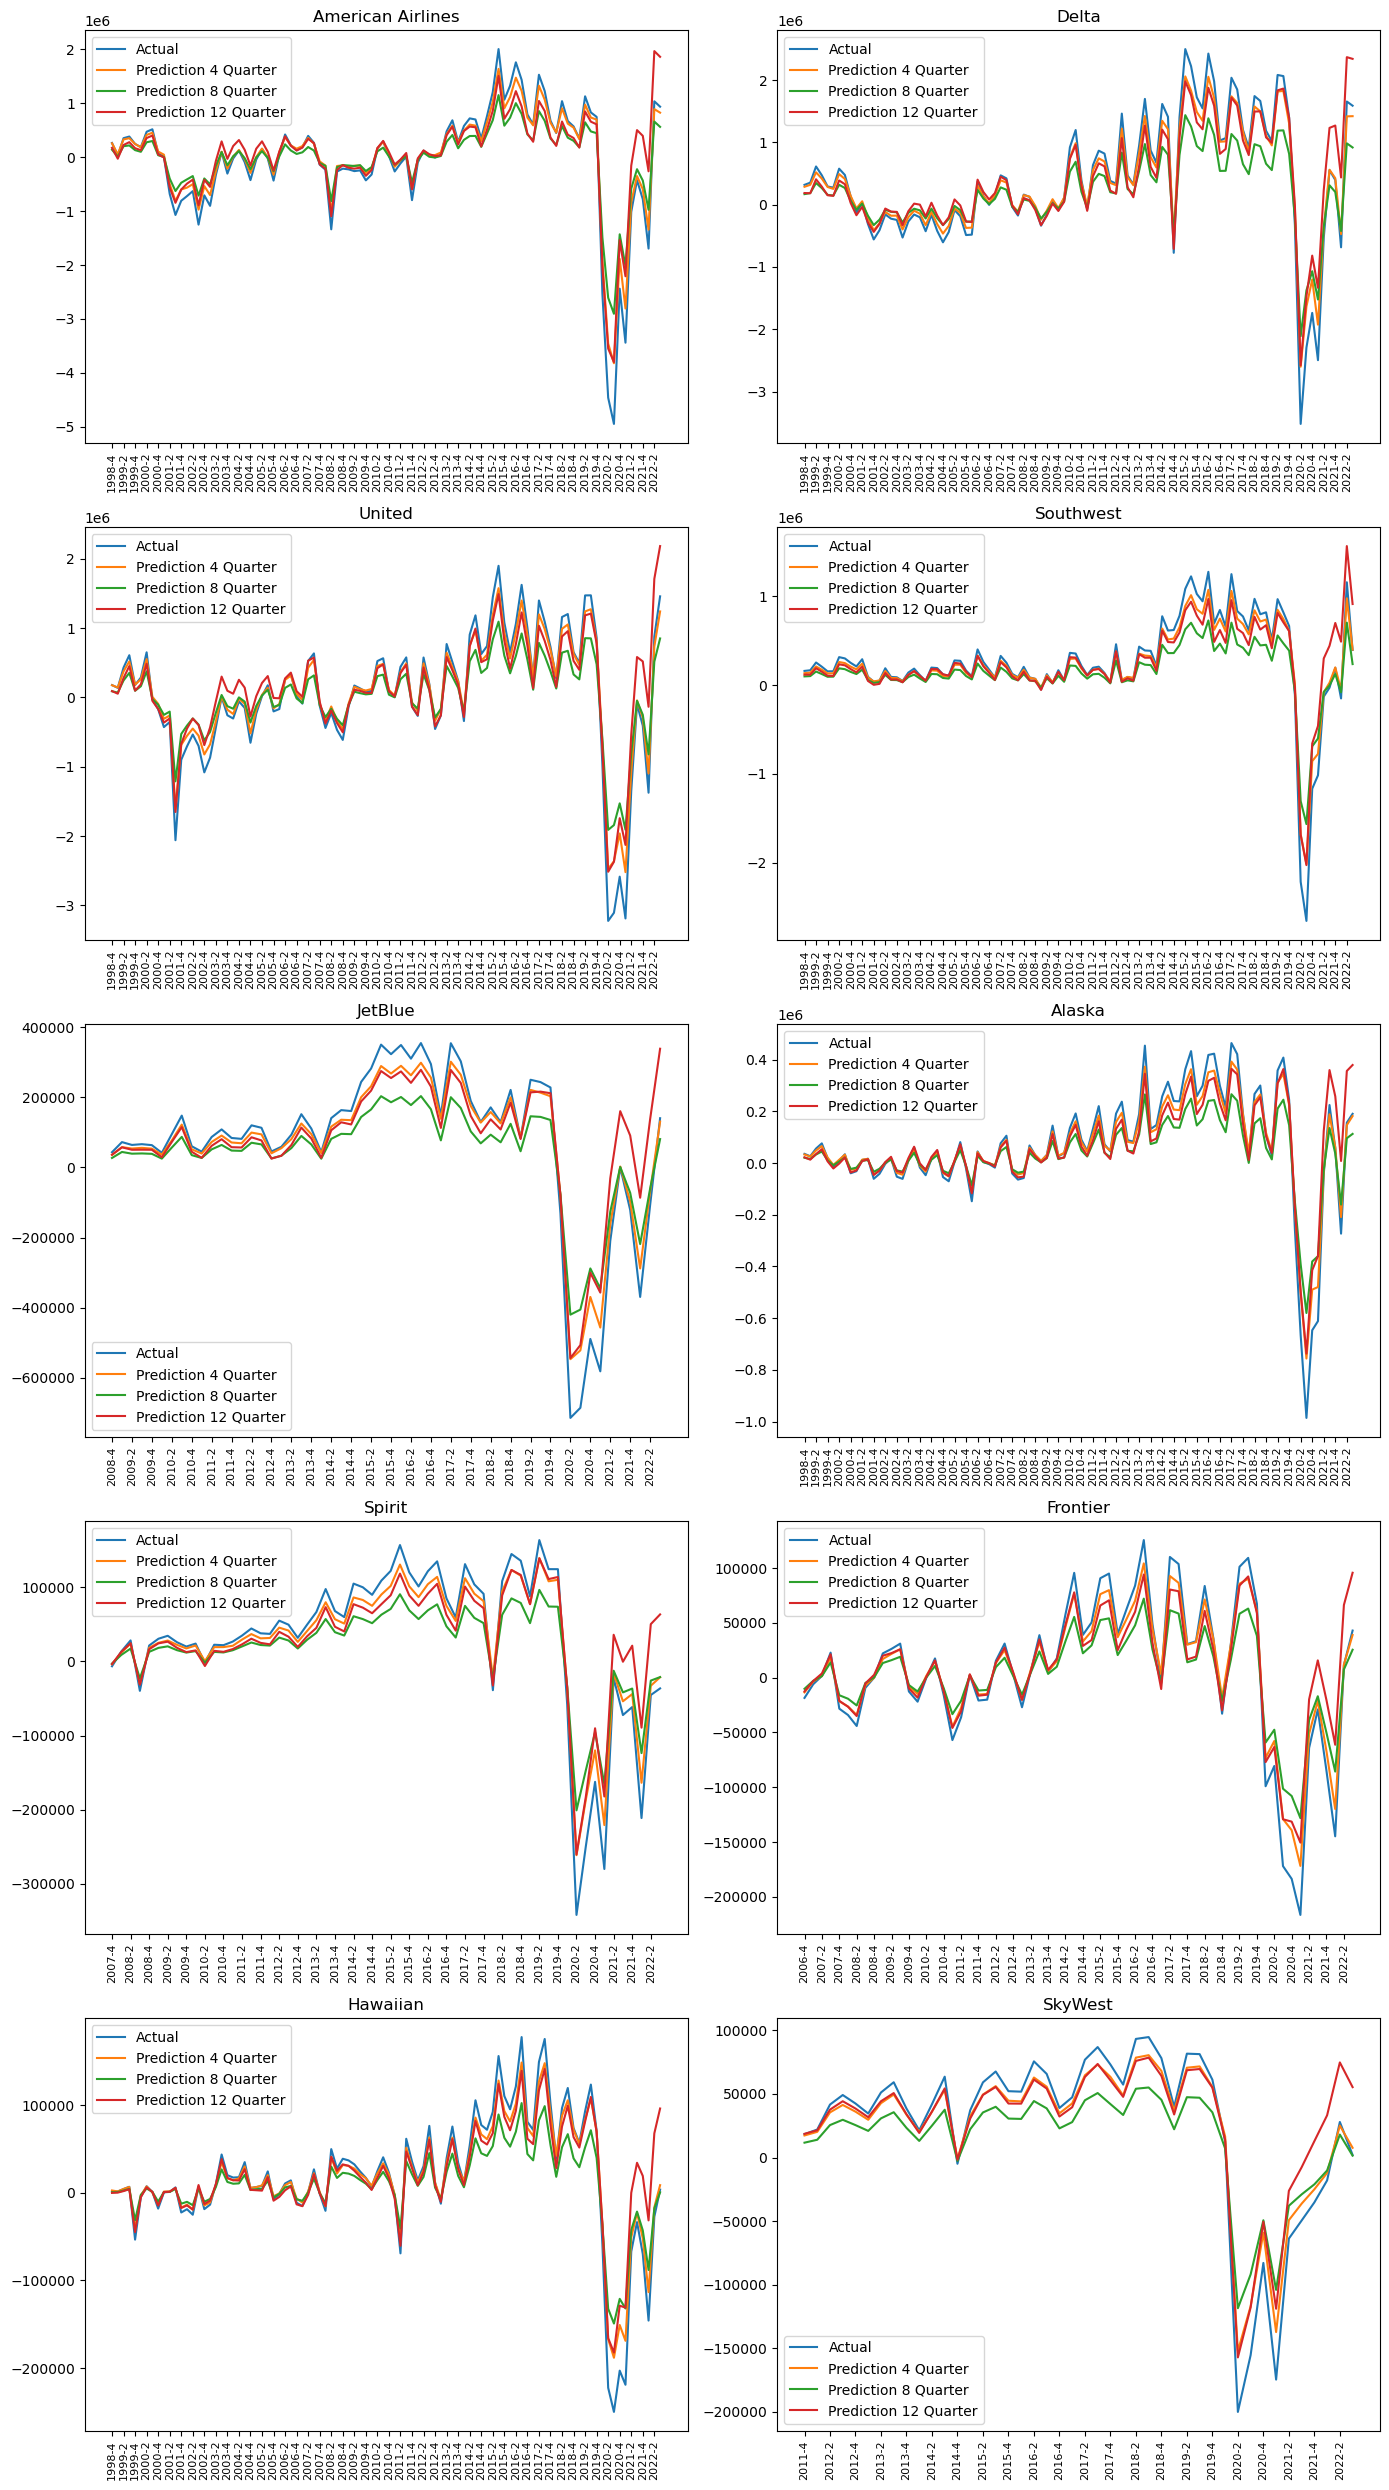

Median relative error for 4 quarter horizon: 0.16178728180170504
Mean relative error for 4 quarter horizon: 0.27925859781664875


In [216]:
all_relative_errors = []

# Create subplots with 2 columns
fig, axs = plt.subplots(len(airlineIDs)//2, 2, figsize=(14, 5*len(airlineIDs)//2))

# Flatten the axs array for easier indexing
axs = axs.flatten()

# Iterate over each airline ID and corresponding name
for i, airline_id in enumerate(airlineIDs):
    airline_name = airlineDict[airline_id]

    # Get the column indices for the current airline ID
    col_index = []
    colnames = output_model.columns
    for index, col in enumerate(colnames):  
        try:
            if col.split('_')[1] == str(airline_id):
                col_index.append(index)
        except:
            continue
    j = col_index[0]
    
    # Get the column indices for the profit and prediction columns
    profit_col = f'Profit_{airline_id}'
    prediction_col = f'Prediction_{airline_id}'
    
    # Plot the predicted and actual values for the current airline
    timescale = list(output_model[~output_model.iloc[:,j].isnull()].Time)
    timescale_horizon8 = list(output_model_horizon8[~output_model_horizon8.iloc[:,j].isnull()].Time)
    timescale_horizon12 = list(output_model_horizon12[~output_model_horizon12.iloc[:,j].isnull()].Time)
    axs[i].plot(timescale, output_model[~output_model.iloc[:,j].isnull()].iloc[:,j], label='Actual')
    axs[i].plot(timescale, output_model[~output_model.iloc[:,j].isnull()].iloc[:,j+1], label='Prediction 4 Quarter')
    axs[i].plot(timescale_horizon8, output_model_horizon8[~output_model_horizon8.iloc[:,j].isnull()].iloc[:,j+1], label='Prediction 8 Quarter')
    axs[i].plot(timescale_horizon12, output_model_horizon12[~output_model_horizon12.iloc[:,j].isnull()].iloc[:,j+1], label='Prediction 12 Quarter')
    relative_error_h4 = abs(output_model.iloc[:,j+1] - output_model.iloc[:,j]) / (abs(output_model.iloc[:,j+1])+abs(output_model.iloc[:,j]))
    all_relative_errors.extend(relative_error_h4)  

    
    axs[i].set_title(f'{airline_name}')
    axs[i].legend()
    axs[i].set_xticks(timescale[::2])
    axs[i].tick_params(axis='x', rotation=90, labelsize=8)

# Remove any unused subplots
if len(airlineIDs) % 2 != 0:
    fig.delaxes(axs[-1])

plt.tight_layout()
# plt.savefig(path_to_save_output+'/predictions_for_all_airlines.png') #! Save the plot
plt.show()

all_relative_errors = [error for error in all_relative_errors if not np.isnan(error)]
median_error_h4 = np.median(all_relative_errors)
mean_error_h4 = np.mean(all_relative_errors)
print(f'Median relative error for 4 quarter horizon: {median_error_h4}')
print(f'Mean relative error for 4 quarter horizon: {mean_error_h4}')

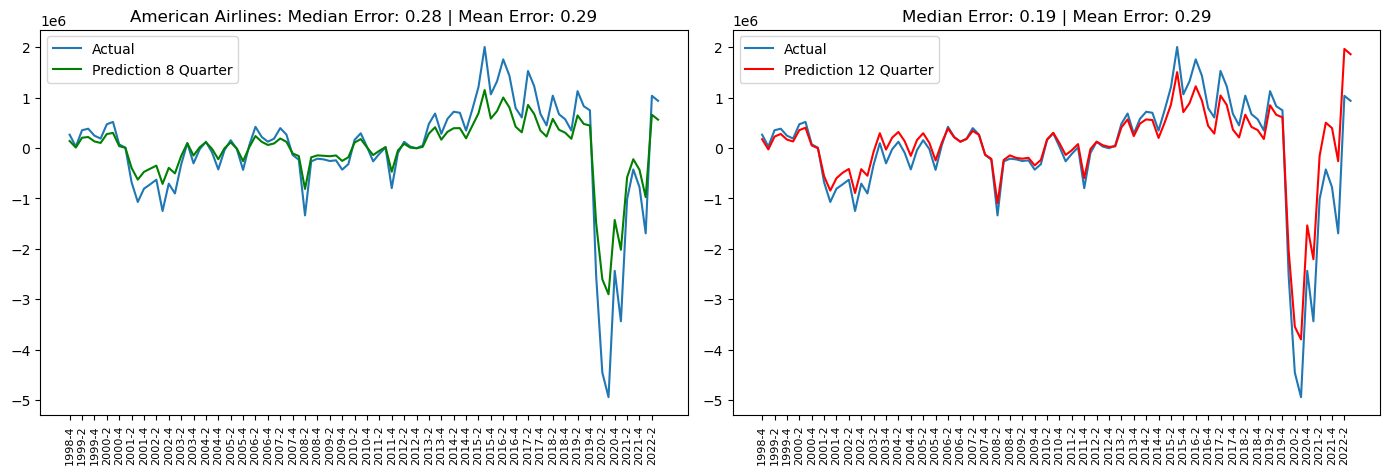

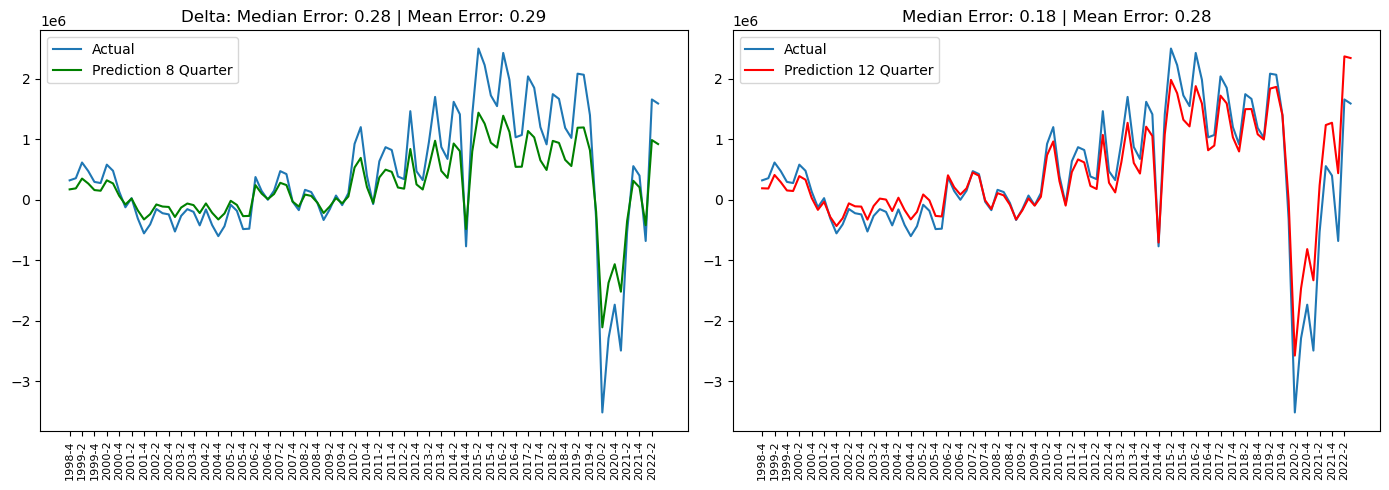

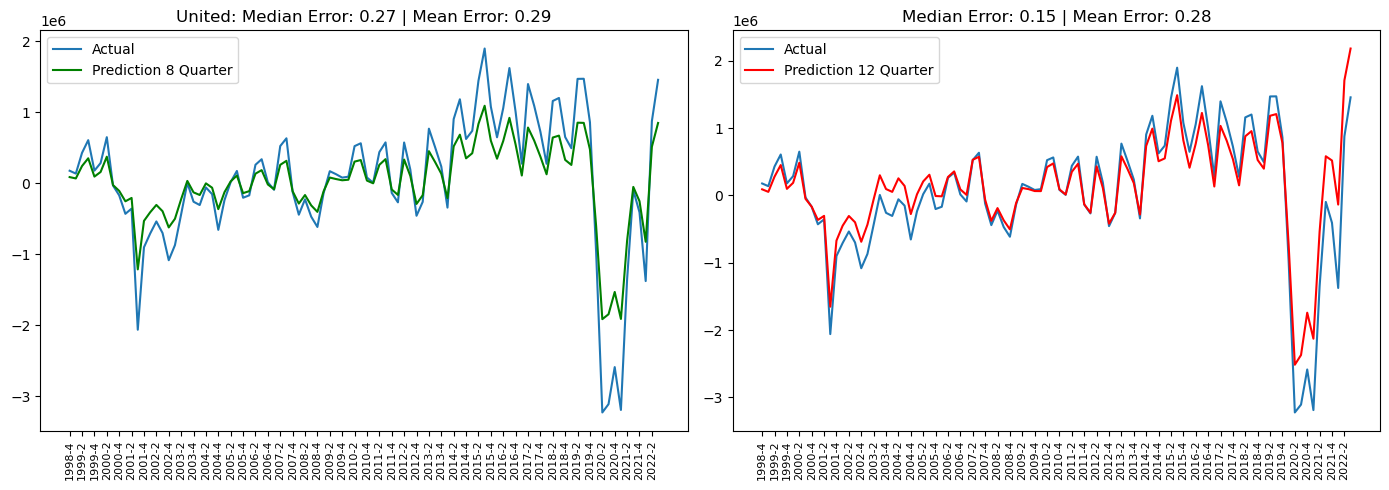

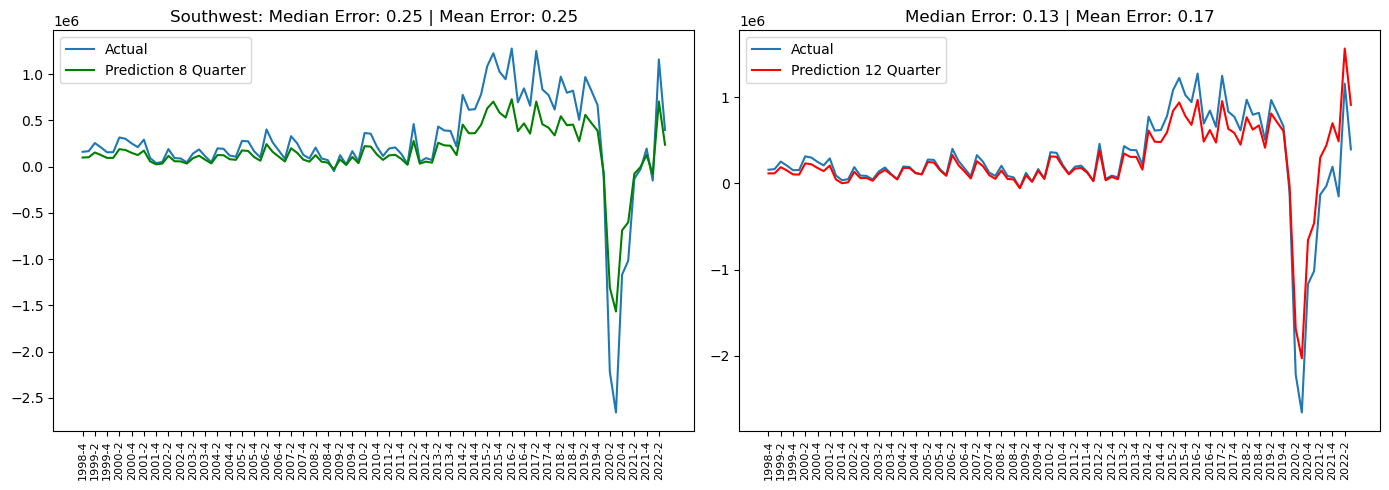

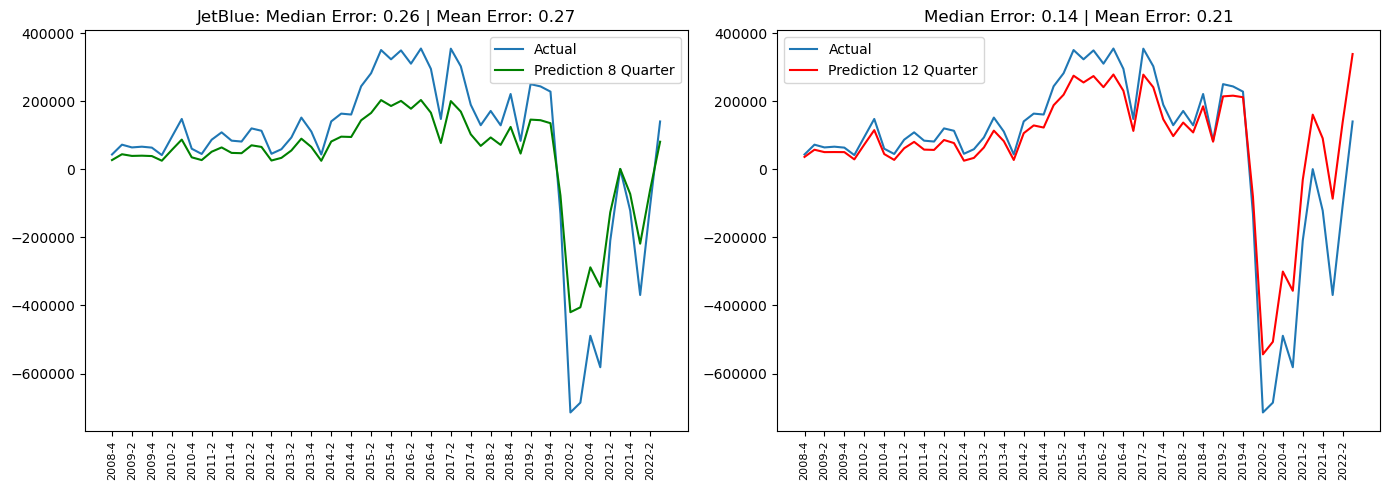

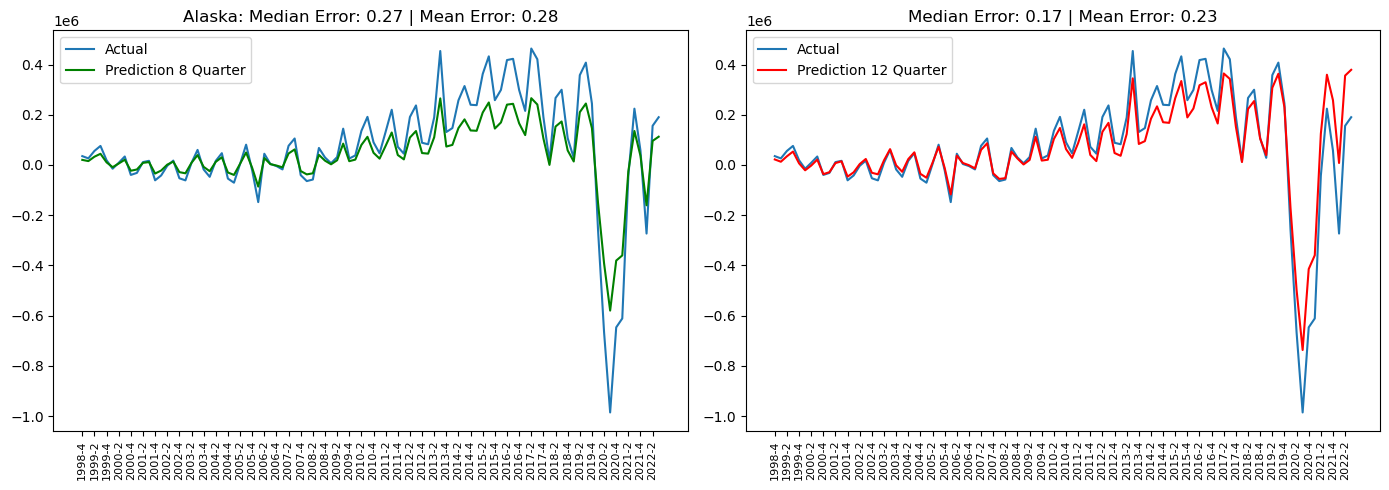

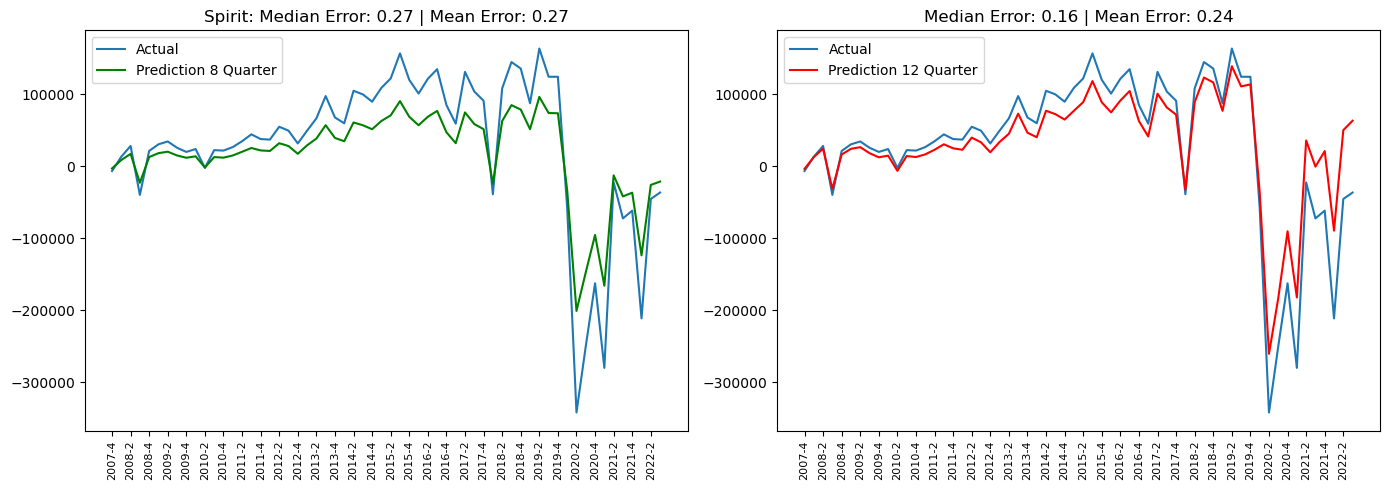

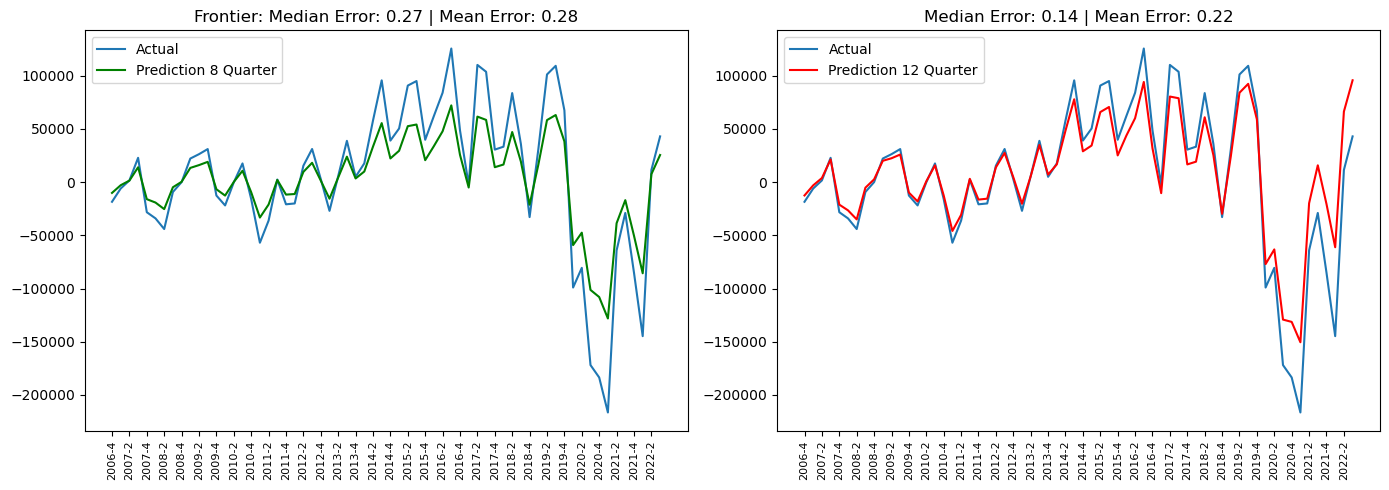

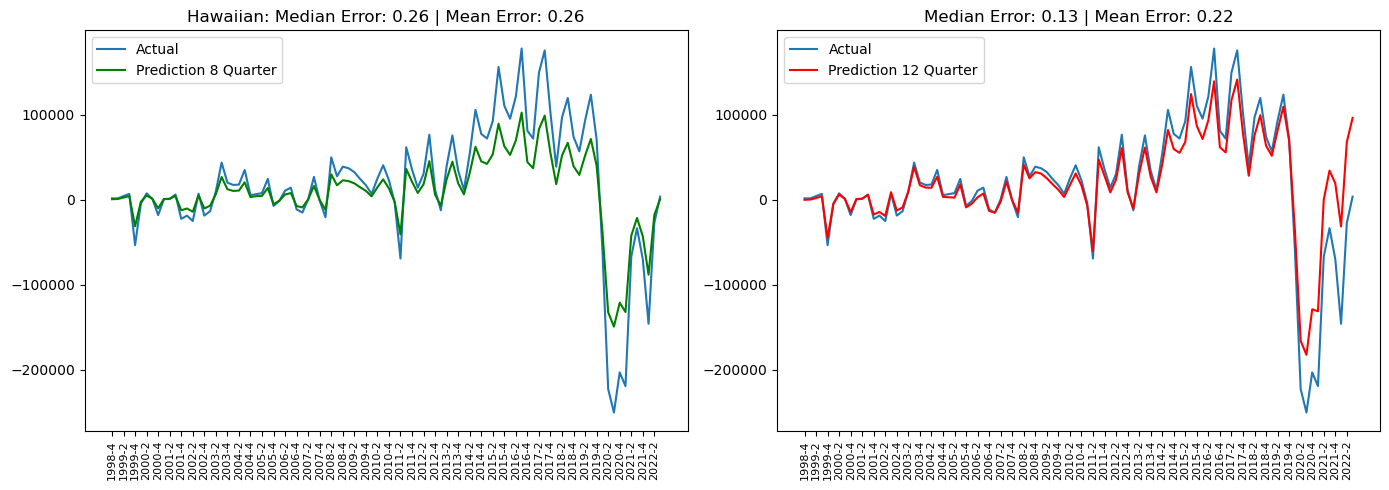

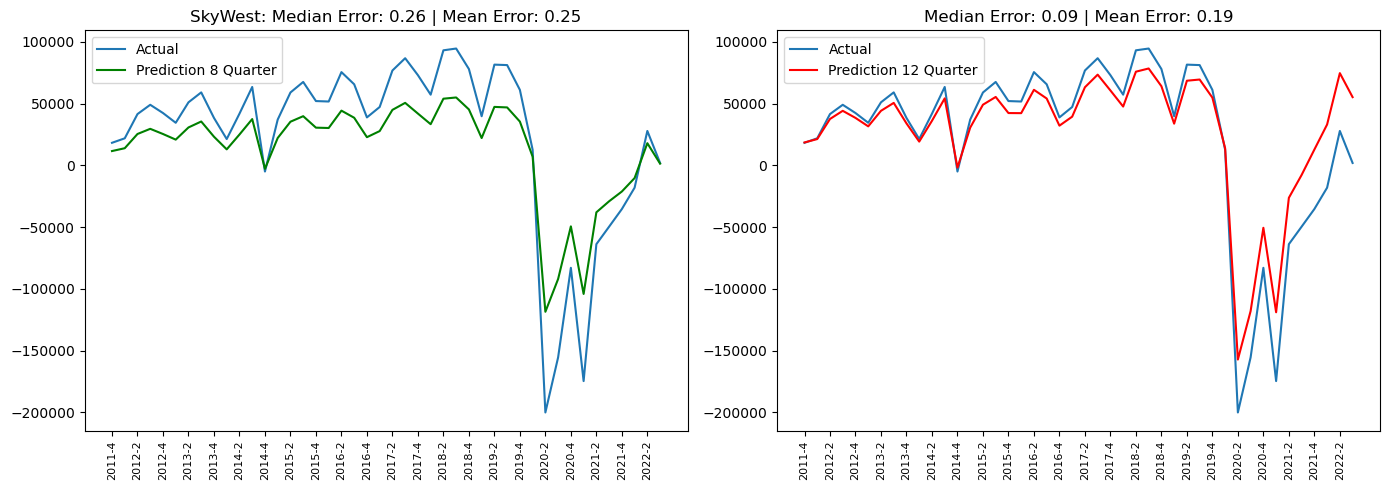

In [117]:


# Iterate over each airline ID and corresponding name
for i, airline_id in enumerate(airlineIDs):
    airline_name = airlineDict[airline_id]

    # Create subplots with 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Flatten the axs array for easier indexing
    axs = axs.flatten()

    # Get the column indices for the current airline ID
    col_index = []
    colnames = output_model.columns
    for index, col in enumerate(colnames):  
        try:
            if col.split('_')[1] == str(airline_id):
                col_index.append(index)
        except:
            continue
    j = col_index[0]
    
    # Get the column indices for the profit and prediction columns
    profit_col = f'Profit_{airline_id}'
    prediction_col = f'Prediction_{airline_id}'
    
    # Plot the predicted and actual values for the current airline
    timescale = list(output_model[~output_model.iloc[:,j].isnull()].Time)
    timescale_horizon8 = list(output_model_horizon8[~output_model_horizon8.iloc[:,j].isnull()].Time)
    timescale_horizon12 = list(output_model_horizon12[~output_model_horizon12.iloc[:,j].isnull()].Time)
    
    axs[0].plot(timescale, output_model[~output_model.iloc[:,j].isnull()].iloc[:,j], label='Actual')
    axs[0].plot(timescale_horizon8, output_model_horizon8[~output_model_horizon8.iloc[:,j].isnull()].iloc[:,j+1], label='Prediction 8 Quarter', color='green')
    relative_error_h8 = abs(output_model_horizon8.iloc[:,j+1] - output_model_horizon8.iloc[:,j]) / (abs(output_model_horizon8.iloc[:,j+1])+abs(output_model_horizon8.iloc[:,j]))
    
    relative_error_h8 = [error for error in relative_error_h8 if not np.isnan(error)]
    median_error_h8 = np.median(relative_error_h8)
    mean_error_h8 = np.mean(relative_error_h8)

    axs[1].plot(timescale, output_model[~output_model.iloc[:,j].isnull()].iloc[:,j], label='Actual')
    axs[1].plot(timescale_horizon12, output_model_horizon12[~output_model_horizon12.iloc[:,j].isnull()].iloc[:,j+1], label='Prediction 12 Quarter' , color='red')
    relative_error_h12 = abs(output_model_horizon12.iloc[:,j+1] - output_model_horizon12.iloc[:,j]) / (abs(output_model_horizon12.iloc[:,j+1])+abs(output_model_horizon12.iloc[:,j]))

    relative_error_h12 = [error for error in relative_error_h12 if not np.isnan(error)]
    median_error_h12 = np.median(relative_error_h12)
    mean_error_h12 = np.mean(relative_error_h12)

    axs[0].set_title(f'{airline_name}: Median Error: {median_error_h8:.2f} | Mean Error: {mean_error_h8:.2f}')
    axs[0].legend()
    axs[0].set_xticks(timescale[::2])
    axs[0].tick_params(axis='x', rotation=90, labelsize=8)

    axs[1].set_title(f'Median Error: {median_error_h12:.2f} | Mean Error: {mean_error_h12:.2f}')
    axs[1].legend()
    axs[1].set_xticks(timescale[::2])
    axs[1].tick_params(axis='x', rotation=90, labelsize=8)


    plt.tight_layout()
    # plt.savefig(path_to_save_output+f'/predictions_for_{airline_name}.png') #! Save the plot
    plt.show()

### Predicted vs Actual Profit in relative number

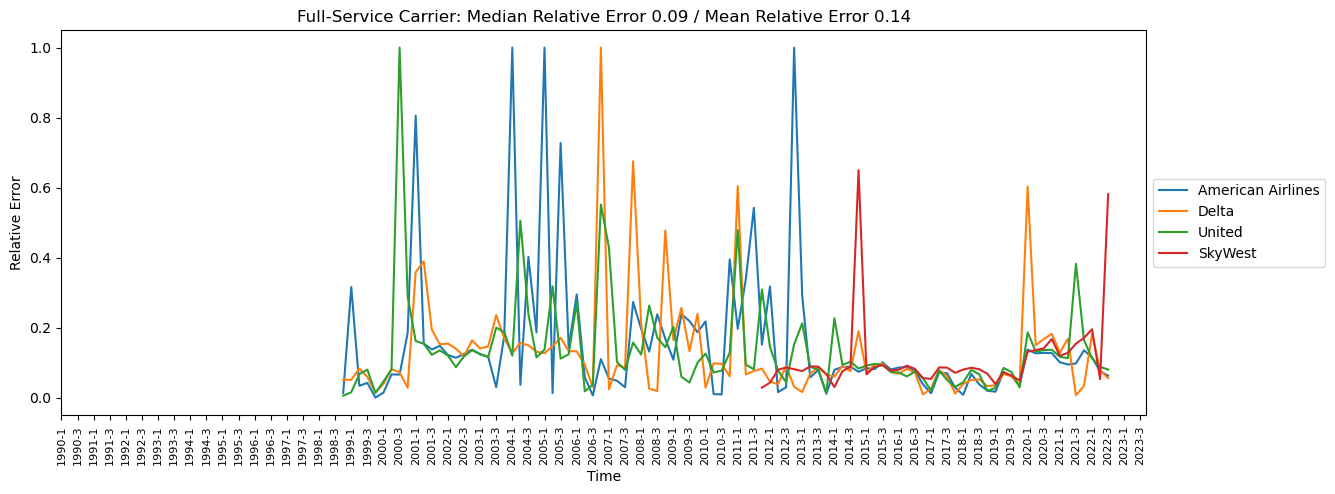

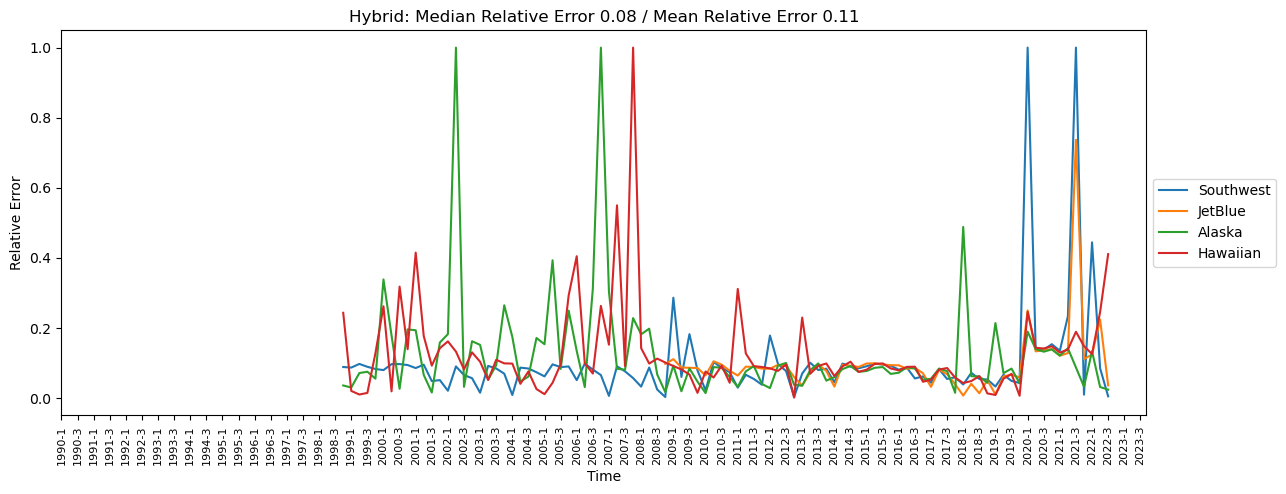

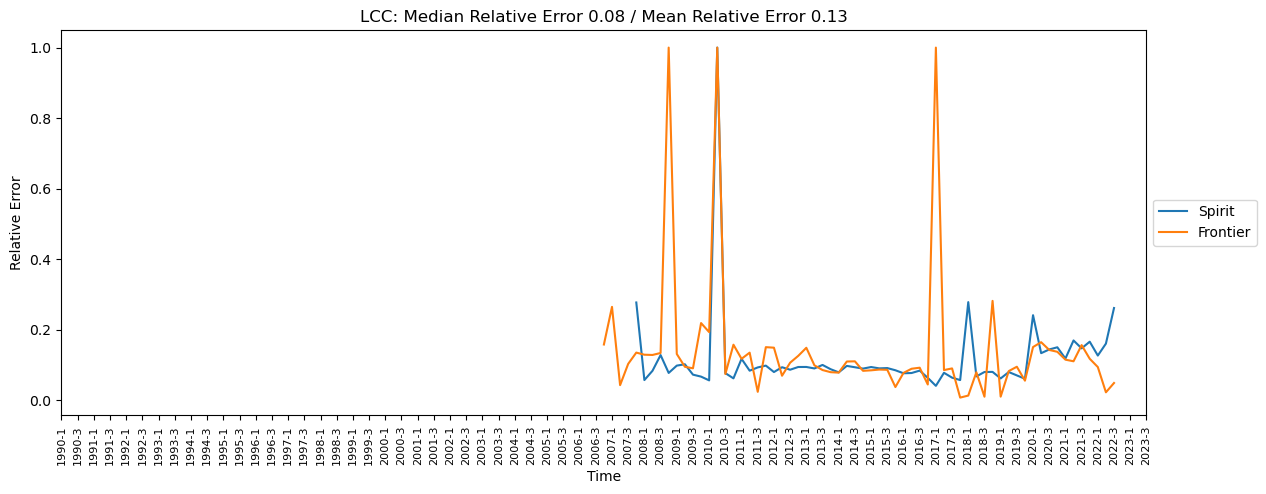

In [168]:
##### FSC ----------------------------------

data_set = output_model

fig, ax = plt.subplots(figsize=(14,5))

all_relative_errors = []
for i in range(1, len(data_set.columns), 2):
    id = data_set.columns[i].split('_')[1] #extract id from the column name
    if int(id) in fsc_IDs:
        airline_name = airlineDict[int(id)] #look up the airline name
        timescale = list(data_set.iloc[:,0])

        relative_error = abs(data_set.iloc[:,i+1] - data_set.iloc[:,i]) / (abs(data_set.iloc[:,i+1])+abs(data_set.iloc[:,i]))
        all_relative_errors.extend(relative_error)  
        ax.plot(timescale, relative_error, label=airline_name)
    else:
        continue

all_relative_errors = [error for error in all_relative_errors if not np.isnan(error)]
median_error = np.median(all_relative_errors)
mean_error = np.mean(all_relative_errors)
ax.set_xlabel('Time')
ax.set_ylabel('Relative Error')
ax.set_title(f'Full-Service Carrier: Median Relative Error {median_error:.2f} / Mean Relative Error {mean_error:.2f}') 
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.tick_params(axis='x', rotation=90, labelsize=8)

# Show only every second x-label
# Get current tick positions and labels
current_ticks = ax.get_xticks()
current_labels = [label.get_text() for label in ax.get_xticklabels()]

# Select every second tick and label
every_second_tick = current_ticks[::2]
every_second_label = current_labels[::2]

# Set the new ticks and labels
ax.set_xticks(every_second_tick)
ax.set_xticklabels(every_second_label, rotation=90)

# fig.savefig(path_to_save_output+'/relative_error_fsc_airlines.png') #! Save the plot
plt.show()  

##### Hybrid ----------------------------------

fig, ax = plt.subplots(figsize=(14,5))
all_relative_errors = []
for i in range(1, len(data_set.columns), 2):
    id = data_set.columns[i].split('_')[1] #extract id from the column name
    if int(id) in hybrid_IDs:
        airline_name = airlineDict[int(id)] #look up the airline name
        timescale = list(data_set.iloc[:,0])

        relative_error = abs(data_set.iloc[:,i+1] - data_set.iloc[:,i]) / (abs(data_set.iloc[:,i+1])+abs(data_set.iloc[:,i]))
        all_relative_errors.extend(relative_error)
        ax.plot(timescale, relative_error, label=airline_name)
    else:
        continue

all_relative_errors = [error for error in all_relative_errors if not np.isnan(error)]
median_error = np.median(all_relative_errors)
mean_error = np.mean(all_relative_errors)
ax.set_xlabel('Time')
ax.set_ylabel('Relative Error')
ax.set_title(f'Hybrid: Median Relative Error {median_error:.2f} / Mean Relative Error {mean_error:.2f}') 
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.tick_params(axis='x', rotation=90, labelsize=8)

# Show only every second x-label
# Get current tick positions and labels
current_ticks = ax.get_xticks()
current_labels = [label.get_text() for label in ax.get_xticklabels()]

# Select every second tick and label
every_second_tick = current_ticks[::2]
every_second_label = current_labels[::2]

# Set the new ticks and labels
ax.set_xticks(every_second_tick)
ax.set_xticklabels(every_second_label, rotation=90)

# fig.savefig(path_to_save_output+'/relative_error_hybrid_airlines.png') #! Save the plot
plt.show()  

##### LCC ----------------------------------

fig, ax = plt.subplots(figsize=(14,5))

all_relative_errors = []
for i in range(1, len(data_set.columns), 2):
    id = data_set.columns[i].split('_')[1] #extract id from the column name
    if int(id) in lcc_IDs:
        airline_name = airlineDict[int(id)] #look up the airline name
        timescale = list(data_set.iloc[:,0])

        relative_error = abs(data_set.iloc[:,i+1] - data_set.iloc[:,i]) / (abs(data_set.iloc[:,i+1])+abs(data_set.iloc[:,i]))
        all_relative_errors.extend(relative_error)  
        ax.plot(timescale, relative_error, label=airline_name)
    else:
        continue

all_relative_errors = [error for error in all_relative_errors if not np.isnan(error)]
mean_error = np.mean(all_relative_errors)
ax.set_xlabel('Time')
ax.set_ylabel('Relative Error')
ax.set_title(f'LCC: Median Relative Error {median_error:.2f} / Mean Relative Error {mean_error:.2f}') 
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.tick_params(axis='x', rotation=90, labelsize=8)

# Show only every second x-label
# Get current tick positions and labels
current_ticks = ax.get_xticks()
current_labels = [label.get_text() for label in ax.get_xticklabels()]

# Select every second tick and label
every_second_tick = current_ticks[::2]
every_second_label = current_labels[::2]

# Set the new ticks and labels
ax.set_xticks(every_second_tick)
ax.set_xticklabels(every_second_label, rotation=90)

# fig.savefig(path_to_save_output+'/relative_error_lcc_airlines.png') #! Save the plot
plt.show()  

In [ ]:
all_relative_errors = np.nan_to_num(all_relative_errors, nan=0.0)

### Prediction on unseen Data

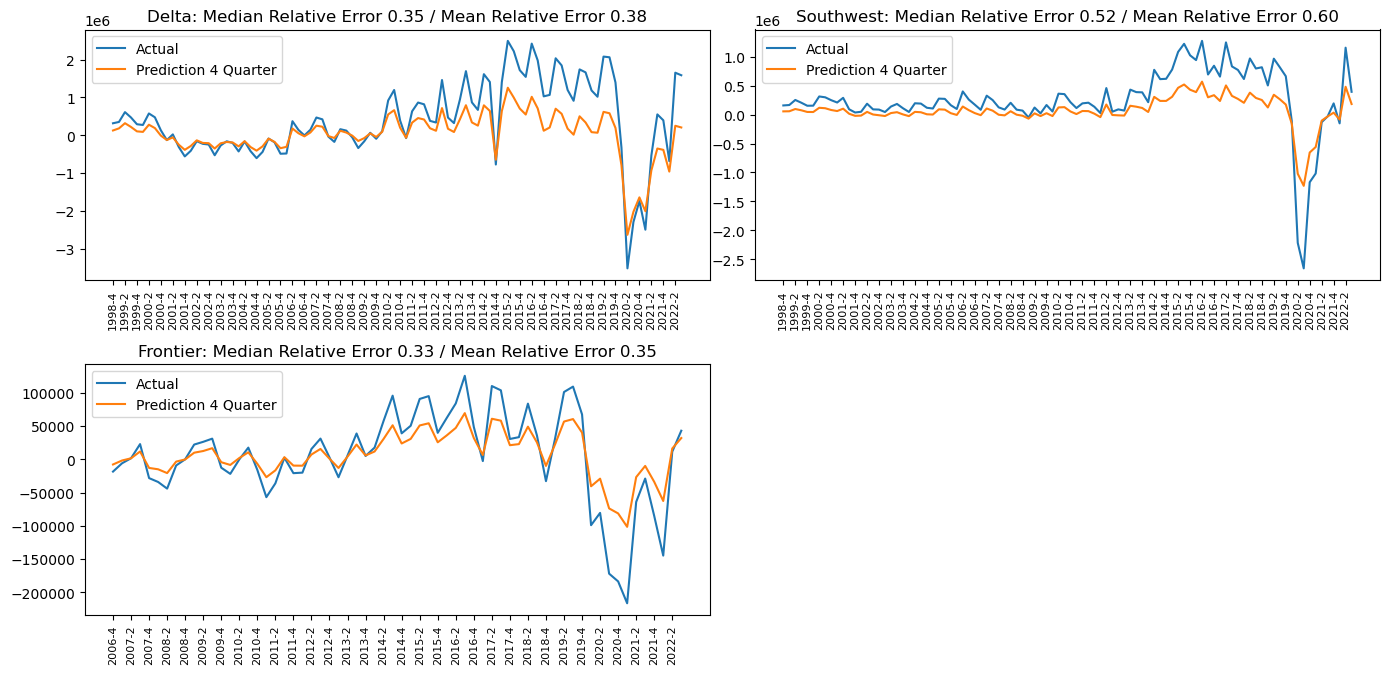

In [109]:

# Create subplots with 2 columns

airline_id_unseen = [19790, 19393, 20436]

fig, axs = plt.subplots(4//2, 2, figsize=(14, 5*len(airline_id_unseen)//2))

# Flatten the axs array for easier indexing
axs = axs.flatten()

# Iterate over each airline ID and corresponding name
for i, airline_id in enumerate(airline_id_unseen):
    airline_name = airlineDict[airline_id]

    # Get the column indices for the current airline ID
    col_index = []
    colnames = output_unseen_data.columns
    for index, col in enumerate(colnames):  
        try:
            if col.split('_')[1] == str(airline_id):
                col_index.append(index)  
        except:
            continue


    j = col_index[0]

    # Get the column indices for the profit and prediction columns
    profit_col = f'Profit_{airline_id}'
    prediction_col = f'Prediction_{airline_id}'
    
    # Plot the predicted and actual values for the current airline
    timescale = list(output_unseen_data[~output_unseen_data.iloc[:,j].isnull()].Time)
    axs[i].plot(timescale, output_unseen_data[~output_unseen_data.iloc[:,j].isnull()].iloc[:,j], label='Actual')
    axs[i].plot(timescale, output_unseen_data[~output_unseen_data.iloc[:,j].isnull()].iloc[:,j+1], label='Prediction 4 Quarter')
    relative_error = abs(output_unseen_data.iloc[:,j+1] - output_unseen_data.iloc[:,j]) / (abs(output_unseen_data.iloc[:,j+1])+abs(output_unseen_data.iloc[:,j]))
    
    relative_error = [error for error in relative_error if not np.isnan(error)]
    median_error = np.median(relative_error)
    mean_error = np.mean(relative_error)
    axs[i].set_title(f'{airline_name}: Median Relative Error {median_error:.2f} / Mean Relative Error {mean_error:.2f}')
    axs[i].legend()
    axs[i].set_xticks(timescale[::2])
    axs[i].tick_params(axis='x', rotation=90, labelsize=8)

# Remove any unused subplots
if len(airline_id_unseen) % 2 != 0:
    fig.delaxes(axs[-1])

plt.tight_layout()
# plt.savefig(path_to_save_output+'/predictions_for_unseen_airlines.png') #! Save the plot#
plt.show()

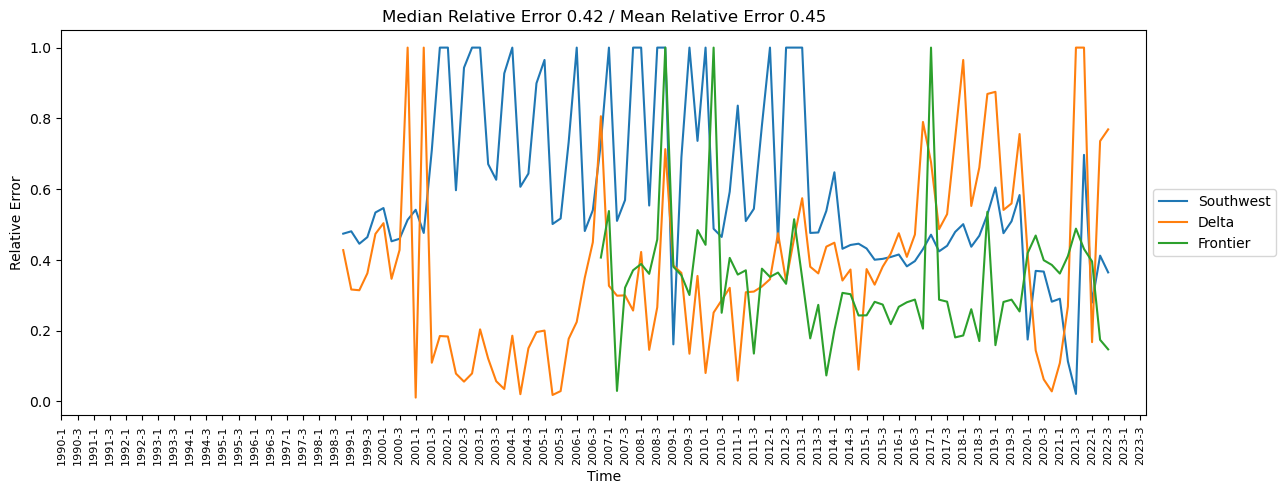

In [103]:
data_set = output_unseen_data

fig, ax = plt.subplots(figsize=(14,5))

all_relative_errors = []
for i in range(1, len(data_set.columns), 2):
    id = data_set.columns[i].split('_')[1] #extract id from the column name
    airline_name = airlineDict[int(id)] #look up the airline name
    timescale = list(data_set.iloc[:,0])

    relative_error = abs(data_set.iloc[:,i+1] - data_set.iloc[:,i]) / (abs(data_set.iloc[:,i+1])+abs(data_set.iloc[:,i]))
    all_relative_errors.extend(relative_error)  
    ax.plot(timescale, relative_error, label=airline_name)


all_relative_errors = [error for error in all_relative_errors if not np.isnan(error)]
median_error = np.median(all_relative_errors)
mean_error = np.mean(all_relative_errors)
ax.set_xlabel('Time')
ax.set_ylabel('Relative Error')
ax.set_title(f'Median Relative Error {median_error:.2f} / Mean Relative Error {mean_error:.2f}') 
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.tick_params(axis='x', rotation=90, labelsize=8)

# Show only every second x-label
# Get current tick positions and labels
current_ticks = ax.get_xticks()
current_labels = [label.get_text() for label in ax.get_xticklabels()]

# Select every second tick and label
every_second_tick = current_ticks[::2]
every_second_label = current_labels[::2]

# Set the new ticks and labels
ax.set_xticks(every_second_tick)
ax.set_xticklabels(every_second_label, rotation=90)

# fig.savefig(path_to_save_output+'/relative_error_lcc_airlines.png')
plt.show()  

# SMAPE Calculation

When visualizing the relative error between two time series that can have both positive and negative values, it's important to choose a metric that accurately reflects the difference in a way that is meaningful and easy to interpret. One commonly used measurement is the Mean Absolute Percentage Error (MAPE), but it has limitations, especially with values close to zero or negative values. An alternative that can handle positive and negative values more gracefully is the Symmetric Mean Absolute Percentage Error (SMAPE).

SMAPE is a better choice in many cases because it treats overestimates and underestimates equally and does not infinitely penalize values when the actual value is zero. It's defined as follows:

[ \text{SMAPE} = \frac{100%}{n} \sum_{t=1}^{n} \frac{|F_t - A_t|}{(|A_t| + |F_t|)/2} ]

Where:

(F_t) is the forecasted value.
(A_t) is the actual value.
(n) is the number of observations.
SMAPE has a range of [0, 200]%, where 0% indicates perfect accuracy and 200% indicates the worst possible accuracy. This metric is symmetric, meaning that it treats overestimations and underestimations equally, making it a fair measure when comparing the accuracy of different forecasting models or time series data.



In [70]:
#Calcualting the smape for every airline
smape_values = []
def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

for i in range(1, len(output_model.columns), 2):
    id = output_model.columns[i].split('_')[1] #extract id from the column name
    airline_name = airlineDict[int(id)] #look up the airline name
    y_true = output_model[~output_model.iloc[:,i].isnull()].iloc[:,i]
    y_pred = output_model[~output_model.iloc[:,i].isnull()].iloc[:,i+1]
    smape_value = smape(y_true, y_pred)
    smape_values.append(smape_value)
    print(f'SMAPE for {airline_name}: {smape_value}')


SMAPE for American Airlines: 31.556579740665246
SMAPE for Delta: 26.06778221501958
SMAPE for United: 27.611561104940446
SMAPE for Southwest: 19.88069828415798
SMAPE for JetBlue: 19.362768973226455
SMAPE for Alaska: 24.90745265208969
SMAPE for Spirit: 23.815771220080908
SMAPE for Frontier: 29.39582367908402
SMAPE for Hawaiian: 25.234854383010045
SMAPE for SkyWest: 22.44673626381988


## Draw Transfer Entropy Matrix

#### Data Set used in the model

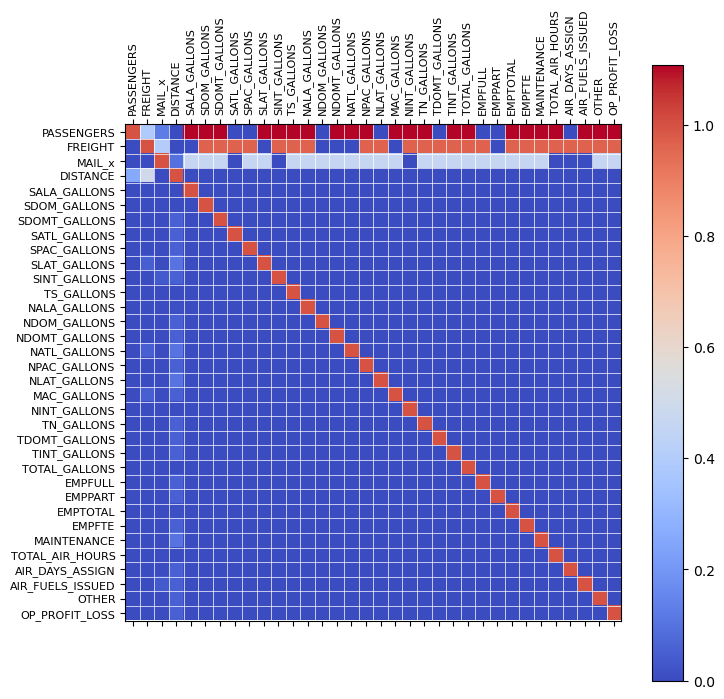

In [204]:
file = './TENet_master/TE/form41_aggregated_quarterly_LargeUSC_reduced_TE.txt'
data_set_file = pd.read_csv('Data/form41_aggregated_quarterly_reduced_LargeUSC.csv')
columns = data_set_file.columns.drop(['AIRLINE_ID','YEAR', 'QUARTER', 'UNIQUE_CARRIER_NAME'])

A = np.loadtxt(file)
A = np.array(A, dtype=np.float32)

# Display matrix
fig, ax = plt.subplots(figsize=(8,8))
cax = ax.matshow(A, cmap='coolwarm')

# Set axis labels
ax.set_xticks(np.arange(len(columns)))
ax.set_yticks(np.arange(len(columns)))
ax.set_xticklabels(columns, rotation=90, fontsize=8)
ax.set_yticklabels(columns, fontsize=8)
# Drawing grid lines manually for a grid-like appearance
for i in range(len(columns)+1):
    ax.axhline(y=i-0.5, color='white', linestyle='-', linewidth=0.5)
    ax.axvline(x=i-0.5, color='white', linestyle='-', linewidth=0.5)

# Adding a colorbar
fig.colorbar(cax, ax=ax, orientation='vertical')

plt.savefig(path_to_save_output+'/te_form41_reduced.png')

plt.show()

#### Reduced Data Set to 6 PCs

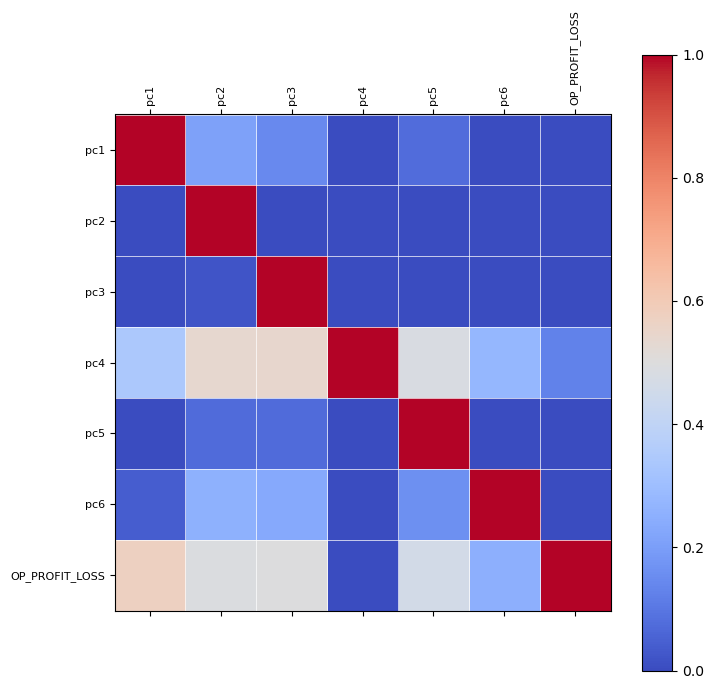

In [205]:
file = 'TENet_master/TE/form41_aggregated_quarterly_pca6_TE.txt'
data_set_file = pd.read_csv('Data/form41_aggregated_quarterly_pca6.csv')

columns = data_set_file.columns.drop(['AIRLINE_ID'])

A = np.loadtxt(file)
A = np.array(A, dtype=np.float32)

# Display matrix
fig, ax = plt.subplots(figsize=(8,8))
cax = ax.matshow(A, cmap='coolwarm')

# Set axis labels
ax.set_xticks(np.arange(len(columns)))
ax.set_yticks(np.arange(len(columns)))
ax.set_xticklabels(columns, rotation=90, fontsize=8)
ax.set_yticklabels(columns, fontsize=8)
# Drawing grid lines manually for a grid-like appearance
for i in range(len(columns)+1):
    ax.axhline(y=i-0.5, color='white', linestyle='-', linewidth=0.5)
    ax.axvline(x=i-0.5, color='white', linestyle='-', linewidth=0.5)

# Adding a colorbar
fig.colorbar(cax, ax=ax, orientation='vertical')

plt.savefig(path_to_save_output+'/te_form41_reduced_pca6.png')

plt.show()

#### Whole Form41 Data Set reduced to 21 PCs

The data set still explains 80% of the variance in the data.

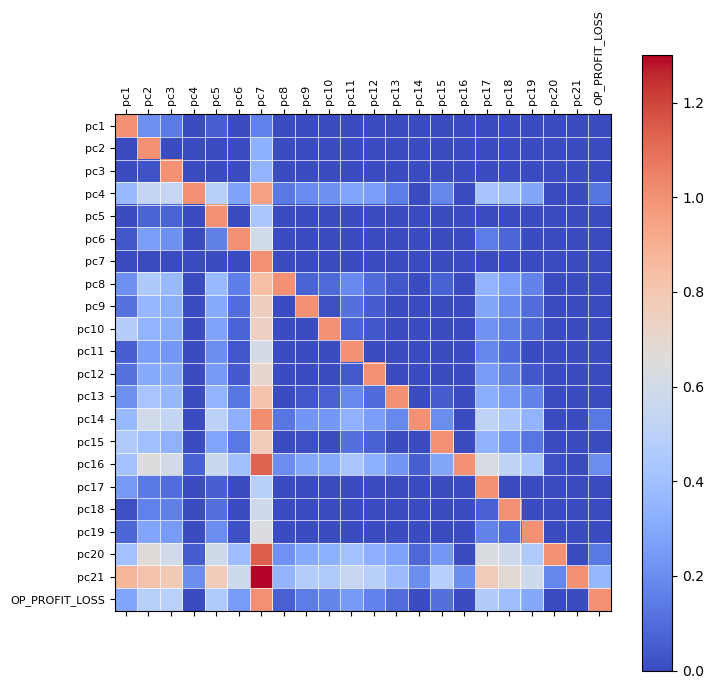

In [206]:
file = 'TENet_master/TE/form41_aggregated_quarterly_pca21_TE.txt'
data_set_file = pd.read_csv('Data/form41_aggregated_quarterly_pca21.csv')

columns = data_set_file.columns.drop(['AIRLINE_ID'])

A = np.loadtxt(file)
A = np.array(A, dtype=np.float32)

# Display matrix
fig, ax = plt.subplots(figsize=(8,8))
cax = ax.matshow(A, cmap='coolwarm')

# Set axis labels
ax.set_xticks(np.arange(len(columns)))
ax.set_yticks(np.arange(len(columns)))
ax.set_xticklabels(columns, rotation=90, fontsize=8)
ax.set_yticklabels(columns, fontsize=8)
# Drawing grid lines manually for a grid-like appearance
for i in range(len(columns)+1):
    ax.axhline(y=i-0.5, color='white', linestyle='-', linewidth=0.5)
    ax.axvline(x=i-0.5, color='white', linestyle='-', linewidth=0.5)


# Adding a colorbar
fig.colorbar(cax, ax=ax, orientation='vertical')
plt.savefig(path_to_save_output+'/te_form41_pca21.png')

plt.show()

### Data Set from the paper

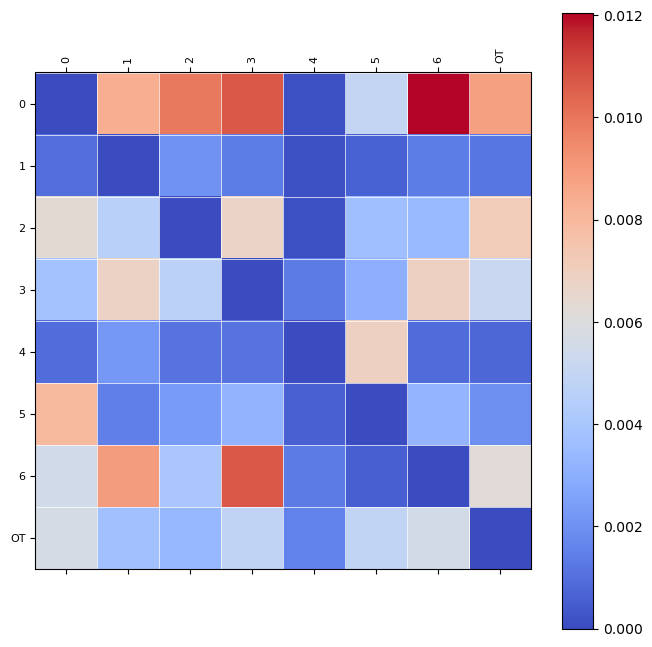

In [207]:
file = 'TENet_master/TE/ex.txt'
data_set_file = pd.read_csv('Data/exchange_rate.csv',sep=';')
columns = data_set_file.columns.drop(['date'])

A = np.loadtxt(file)
A = np.array(A, dtype=np.float32)

# Display matrix
fig, ax = plt.subplots(figsize=(8,8))
cax = ax.matshow(A, cmap='coolwarm')

# Set axis labels
ax.set_xticks(np.arange(len(columns)))
ax.set_yticks(np.arange(len(columns)))
ax.set_xticklabels(columns, rotation=90, fontsize=8)
ax.set_yticklabels(columns, fontsize=8)
# Drawing grid lines manually for a grid-like appearance
for i in range(len(columns)+1):
    ax.axhline(y=i-0.5, color='white', linestyle='-', linewidth=0.5)
    ax.axvline(x=i-0.5, color='white', linestyle='-', linewidth=0.5)

# Adding a colorbar
fig.colorbar(cax, ax=ax, orientation='vertical')

plt.savefig(path_to_save_output+'/te_exchange_rate.png')

plt.show()